In [9]:
from pathlib import Path
from itertools import chain
import pandas as pd
import numpy as np

import json
import sys
sys.path.insert(0, '..')

import shap


from predictor.models import LinearModel
from predictor.preprocessing import VALUE_COLS, VEGETATION_LABELS

from predictor.models import nn_FeedForward
from predictor.analysis import plot_shap_values

In [10]:
path_to_arrays = Path('../data/processed/arrays')

with open('../data/processed/normalizing_dict.json', 'r') as f:
    normalizing_dict = json.load(f)

In [11]:
normalizing_dict

{'lst_night': {'mean': 20.02902850721224, 'std': 4.8347701035649715},
 'lst_day': {'mean': 34.81441970190491, 'std': 6.407296815399471},
 'precip': {'mean': 70.35054918709278, 'std': 79.97758258548158},
 'sm': {'mean': 0.185001452379055, 'std': 0.07275795843782899},
 'spi': {'mean': 0.10414542081040823, 'std': 0.98763159333},
 'spei': {'mean': 0.14068466310471373, 'std': 0.9605460353853802},
 'ndvi': {'mean': 0.40513911424319093, 'std': 0.1855618168485227},
 'evi': {'mean': 0.23928123560173498, 'std': 0.12185360875149595}}

```python
from torch.nn import functional as F

optimizer = torch.optim.Adam
loss = F.smooth_l1_loss

```

In [12]:
model = nn_FeedForward(path_to_arrays, hide_vegetation=True)
model.model

In [56]:
data = model.load_tensors()
model.model

Training model without vegetation features


LinearModel(
  (dense_layers): ModuleList(
    (0): LinearBlock(
      (linear): Linear(in_features=66, out_features=66, bias=False)
      (relu): LeakyReLU(negative_slope=0.1, inplace)
      (batchnorm): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25)
    )
  )
  (final_dense): Linear(in_features=66, out_features=1, bias=True)
)

In [63]:
# print parameters
[print(param,"\n") for param in model.model.parameters()]

Parameter containing:
tensor([[ 0.1676,  0.0928, -0.1070,  ..., -0.1618, -0.2481,  0.1874],
        [-0.1080,  0.0413,  0.1083,  ...,  0.1010,  0.2488, -0.1584],
        [ 0.2497,  0.0314, -0.1826,  ...,  0.2155,  0.0728,  0.2294],
        ...,
        [-0.1098,  0.1792,  0.1246,  ...,  0.1431, -0.0413,  0.2931],
        [-0.2362,  0.0799,  0.2796,  ...,  0.1167,  0.2159,  0.2707],
        [ 0.2956,  0.0077, -0.2101,  ..., -0.1267, -0.0728, -0.1841]],
       requires_grad=True) 

Parameter containing:
tensor([0.0335, 0.0941, 0.1949, 0.7982, 0.7119, 0.2064, 0.9970, 0.2622, 0.0043,
        0.9880, 0.4630, 0.7441, 0.9228, 0.0787, 0.5707, 0.3666, 0.3929, 0.2220,
        0.0379, 0.6305, 0.3542, 0.0542, 0.3685, 0.5442, 0.4685, 0.2569, 0.1518,
        0.8289, 0.9007, 0.6416, 0.4779, 0.4757, 0.5463, 0.1509, 0.9211, 0.4384,
        0.1784, 0.9996, 0.0225, 0.7551, 0.9550, 0.8124, 0.3422, 0.5529, 0.6333,
        0.6898, 0.3213, 0.5680, 0.7176, 0.6922, 0.1839, 0.6716, 0.1880, 0.1939,
        0.760

[None, None, None, None, None]

In [66]:
[print(param.shape,"\n") for param in model.model.parameters()]

torch.Size([66, 66]) 

torch.Size([66]) 

torch.Size([66]) 

torch.Size([1, 66]) 

torch.Size([1]) 



[None, None, None, None, None]

In [67]:
model.train(num_epochs=1)

Training model without vegetation features


  0%|          | 0/8175 [00:00<?, ?it/s]

After split, training on 261593 examples, validating on 29065 examples


100%|██████████| 909/909 [00:01<00:00, 710.25it/s]

Epoch 0 - Training RMSE: 0.07392797214540138, Validation RMSE: 0.07050875135430015


In [69]:
model.evaluate()

100%|██████████| 916/916 [00:01<00:00, 655.22it/s]

Test set RMSE: 0.08510565012693405


In [73]:
background_data = model.load_tensors(mode='train')
test_data = model.load_tensors(mode='test')

Training model without vegetation features


In [74]:
test_x = test_data.x[:2]
test_true = test_data.y[:2]

In [87]:
num_samples = 100
background_x = background_data.x[np.random.randint(0, background_data.x.shape[0], num_samples)]

In [93]:
e = shap.DeepExplainer(model.model, background_x)
display(e)
shap_values = e.shap_values(test_x)


In [94]:
values_no_veg = [val for val in VALUE_COLS if val not in VEGETATION_LABELS]
values_no_veg

['lst_night', 'lst_day', 'precip', 'sm', 'spi', 'spei']

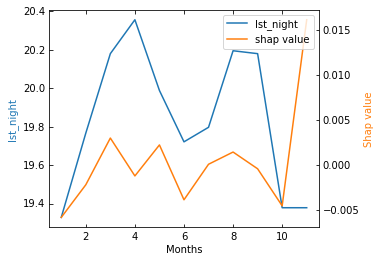

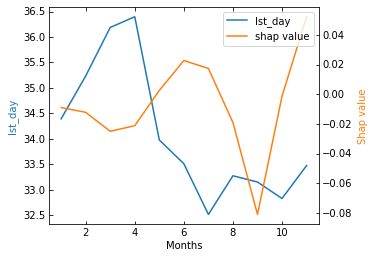

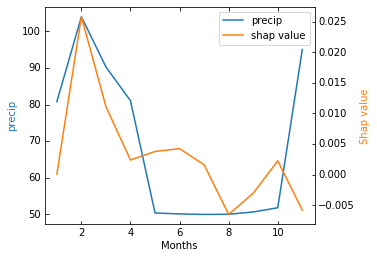

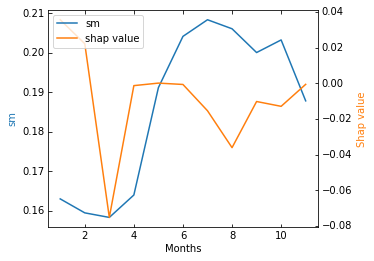

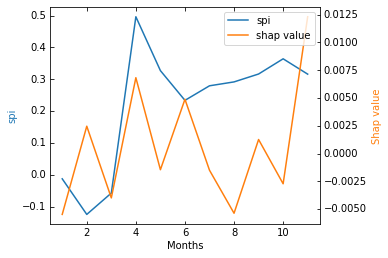

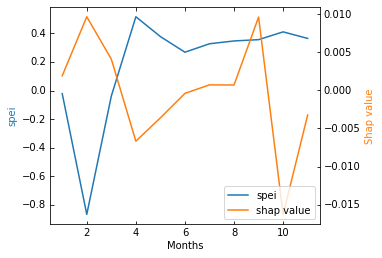

In [98]:
for val_ in values_no_veg:
    plot_shap_values(test_x[0], shap_values[0], values_no_veg, normalizing_dict, val_)